# Check Complexity Measures for Correlation

In [1]:
# get data dictionary
from utils import constants, helpers
import random
import numpy as np
from typing import List, Tuple, Optional

data_dictionary = helpers.load_data_dictionary(constants.DATA_DICTIONARY_FILE_PATH)

In [2]:
def sample_random_trace_sets_no_replacement(
    event_log,
    min_size: int = 10,
    max_size: int = 500,       
    num_sizes: int = 10, 
    samples_per_size: int = 10,
    spacing: str = "linear",              # "linear" or "log"
    random_state: Optional[int] = None
) -> List[Tuple[int, int, list]]:
    """
    Create random, non-consecutive trace sets without replacement,
    automatically choosing sizes based on log length, min_size, and max_size.

    Returns: list of tuples (window_size, sample_id, trace_list)
    """
    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)

    n_traces = len(event_log)
    if n_traces < min_size:
        return []

    # Apply user-defined max_size cap
    if max_size is not None:
        max_size = min(max_size, n_traces)
    else:
        max_size = n_traces

    # Budget = how many traces we can "spend" per repetition
    budget = n_traces // samples_per_size
    if budget < min_size:
        return []

    # The largest feasible size under budget and max_size
    feasible_max_size = min(max_size, budget)

    # --- Generate size list ---
    if spacing.lower() == "linear":
        if num_sizes <= 1 or feasible_max_size <= min_size:
            sizes = np.array([min_size] * max(1, num_sizes), dtype=int)
        else:
            sizes = np.linspace(min_size, feasible_max_size, num_sizes).astype(int)
    else:  # "log" spacing
        if num_sizes <= 1 or feasible_max_size <= min_size:
            sizes = np.array([min_size] * max(1, num_sizes), dtype=int)
        else:
            sizes = np.geomspace(min_size, feasible_max_size, num_sizes).astype(int)

    # Ensure monotonic increase and cap at feasible_max_size
    sizes = np.clip(sizes, min_size, feasible_max_size)
    sizes = np.maximum.accumulate(sizes)

    # Safety: shrink sizes from the end if total budget exceeded
    while sizes.sum() > budget and sizes[-1] > min_size:
        sizes[-1] -= 1

    # --- Sampling without replacement ---
    available = list(range(n_traces))
    results: List[Tuple[int, int, list]] = []

    for sample_id in range(samples_per_size):
        for size in sizes:
            if len(available) < size:
                break
            idxs = random.sample(available, int(size))
            for idx in idxs:
                available.remove(idx)
            chosen_traces = [event_log[i] for i in idxs]
            results.append((int(size), int(sample_id), chosen_traces))

        if len(available) < min_size:
            break

    return results


In [ ]:
DEBUG = True

: 

In [ ]:
from pathlib import Path
import random
import pandas as pd
from pm4py.objects.log.importer.xes import importer as xes_importer
import numpy as np
from utils.process_complexity_adapter import get_measures_for_traces, get_measures_for_windows


measures_per_sample_per_dataset = {}
for dataset, dataset_info in data_dictionary.items():
    print(f"Processing {dataset}")
    # load the log
    log_path = Path(dataset_info["path"])
    pm4py_log = xes_importer.apply(str(log_path))

    sample_sizes = range(100, 1001, 100)
    samples_per_size = 10

    samples = sample_random_trace_sets_no_replacement(
        pm4py_log,
        random_state=0
    )

    # compute complexity for each sample
    measures_per_sample = []  # rows

    # for size, sample_id, traces in samples:
    #     measures = get_measures_for_traces(traces)

    #     # remove "measures_" prefix and remove all none-measures
    #     measures = {measure.removeprefix('measure_'):value for measure, value in measures.items() if measure.startswith('measure_')}

    #     measures_per_sample.append({
    #         **measures,
    #         "window_size": size,
    #         "sample_id": sample_id
    #     })


    # df = pd.DataFrame(measures_per_sample)

    measures_per_sample = []  # rows
    windows = [traces for _, _, traces in samples]
    dictionaries_all_windows = get_measures_for_windows(windows)

    for i, dictionary_per_window in enumerate(dictionaries_all_windows):
        measures = dictionary_per_window
        # remove "measures_" prefix and remove all none-measures
        measures = {measure.removeprefix('measure_'):value for measure, value in measures.items() if measure.startswith('measure_')}

        measures_per_sample.append({
            **measures,
            "window_size": samples[i][0],
            "sample_id": samples[i][1]
        })
    
    df = pd.DataFrame(measures_per_sample)

    measures_per_sample_per_dataset[dataset] = df
    if DEBUG: break

In [ ]:
measures_per_sample_per_dataset['ACCRE']

,Distinct traces (sample) (Own),Distinct traces (full population est.) (Own),Variety (sample) (Own),Variety (full population est.) (Own),Pentland Process Complexity (sample) (Own),Pentland Process Complexity (full population est.) (Own),Magnitude (sample) (Vidgof),Support (sample) (Vidgof),Variety (sample) (Vidgof),Level of detail (sample) (Vidgof),...,Pentland's process complexity (sample) (Vidgof),Variant Entropy (sample) (Vidgof),Normalized Variant Entropy (sample) (Vidgof),Trace Entropy (sample) (Vidgof),Normalized Trace Entropy (sample) (Vidgof),Trace length min (sample) (Vidgof),Trace length avg (sample) (Vidgof),Trace length max (sample) (Vidgof),window_size,sample_id
0,5.0,11.000000,10.0,11.000000,3.019952,1.905461e+05,45,10,10,4.500000,...,3.019952,26.297473,0.505461,46.376483,0.270733,3,4.500000,7,10,0
1,6.0,8.250000,11.0,11.000000,3.019952,9.120108e+00,68,13,11,5.230769,...,3.019952,39.493439,0.490773,89.843779,0.313125,3,5.230769,8,13,0
2,8.0,26.000000,12.0,12.166667,6.309573,1.737801e+02,78,16,12,4.875000,...,6.309573,51.869243,0.555930,103.544777,0.304702,3,4.875000,9,16,0
3,9.0,18.000000,12.0,18.000000,5.248075,1.000000e+06,89,19,12,4.684211,...,5.248075,52.487028,0.514398,111.899725,0.280107,3,4.684211,10,19,0
4,7.0,15.000000,9.0,9.500000,3.630781,1.318257e+01,94,22,9,4.272727,...,3.630781,34.541114,0.540254,98.197798,0.229934,3,4.272727,7,22,0
5,13.0,63.000000,15.0,21.250000,9.120108,3.981072e+01,122,26,15,4.692308,...,9.120108,79.923028,0.619526,172.593658,0.294483,1,4.692308,10,26,0
6,11.0,15.166667,12.0,12.000000,3.630781,1.584893e+01,144,29,12,4.965517,...,3.630781,44.411650,0.524276,160.625336,0.224446,3,4.965517,9,29,0
7,14.0,24.666667,12.0,12.500000,13.182567,1.000000e+04,149,32,12,4.625000,...,13.182567,84.830989,0.634944,215.298616,0.288764,3,4.656250,8,32,0
8,14.0,34.250000,14.0,14.000000,10.964782,4.786301e+01,186,35,14,5.028571,...,10.964782,104.082317,0.532115,300.324777,0.308980,3,5.314286,16,35,0
9,8.0,17.000000,12.0,18.000000,4.365158,1.318257e+01,48,10,12,4.800000,...,4.365158,44.940391,0.558461,75.732636,0.407564,1,4.800000,8,10,0


In [ ]:
import numpy as np
from scipy.stats import pearsonr

correlation_results = {}
for dataset, df in measures_per_sample_per_dataset.items():
    if "window_size" not in df.columns:
        raise KeyError(f"'window_size' missing for dataset {dataset}")

    # choose numeric measure columns, exclude identifiers
    measure_cols = [
        c for c in df.columns
        if c not in ["window_size", "sample_id"]
        and pd.api.types.is_numeric_dtype(df[c])
    ]

    ws = pd.to_numeric(df["window_size"], errors="coerce")
    rows = []
    for col in measure_cols:
        x = pd.to_numeric(df[col], errors="coerce")
        pair = (pd.DataFrame({"x": x, "y": ws})
                .replace([np.inf, -np.inf], np.nan)
                .dropna())
        if len(pair) < 2 or pair["x"].nunique() < 2 or pair["y"].nunique() < 2:
            r, p = np.nan, np.nan
        else:
            r, p = pearsonr(pair["x"].to_numpy(), pair["y"].to_numpy())
        rows.append({"measure": col, "n": len(pair), "pearson_r": r, "p_value": p})

    correlation_results[dataset] = (pd.DataFrame(rows)
                                    .sort_values("measure")
                                    .reset_index(drop=True))


In [ ]:
import pandas as pd

# correlation_results[dataset] = DataFrame with columns: measure, n, pearson_r, p_value
# and one row per measure

# First, reindex each DF by measure and make a MultiIndex column
df_list = []
for dataset, df in correlation_results.items():
    df = df.set_index("measure")[["n", "pearson_r", "p_value"]]
    # Add dataset name as first level of column MultiIndex
    df.columns = pd.MultiIndex.from_product([[dataset], df.columns])
    df_list.append(df)

# Join on the measure index
combined_df = pd.concat(df_list, axis=1)

# Optional: sort measures alphabetically
combined_df = combined_df.sort_index()

print(combined_df)


                                                   ACCRE            \
                                                       n pearson_r   
measure                                                              
Affinity (sample) (Vidgof)                            19  0.305770   
Deviation from random (sample) (Vidgof)               19 -0.282687   
Distinct traces (full population est.) (Own)          19  0.210769   
Distinct traces (sample) (Own)                        19  0.822937   
Distinct traces (sample) (Vidgof)                     19  0.822937   
Lempel-Ziv complexity (sample) (Vidgof)               19  0.909840   
Level of detail (sample) (Vidgof)                     19 -0.317074   
Magnitude (sample) (Vidgof)                           19  0.979630   
Normalized Trace Entropy (sample) (Vidgof)            19 -0.494074   
Normalized Variant Entropy (sample) (Vidgof)          19  0.402978   
Pentland Process Complexity (full population es...    19 -0.300449   
Pentland Process Com

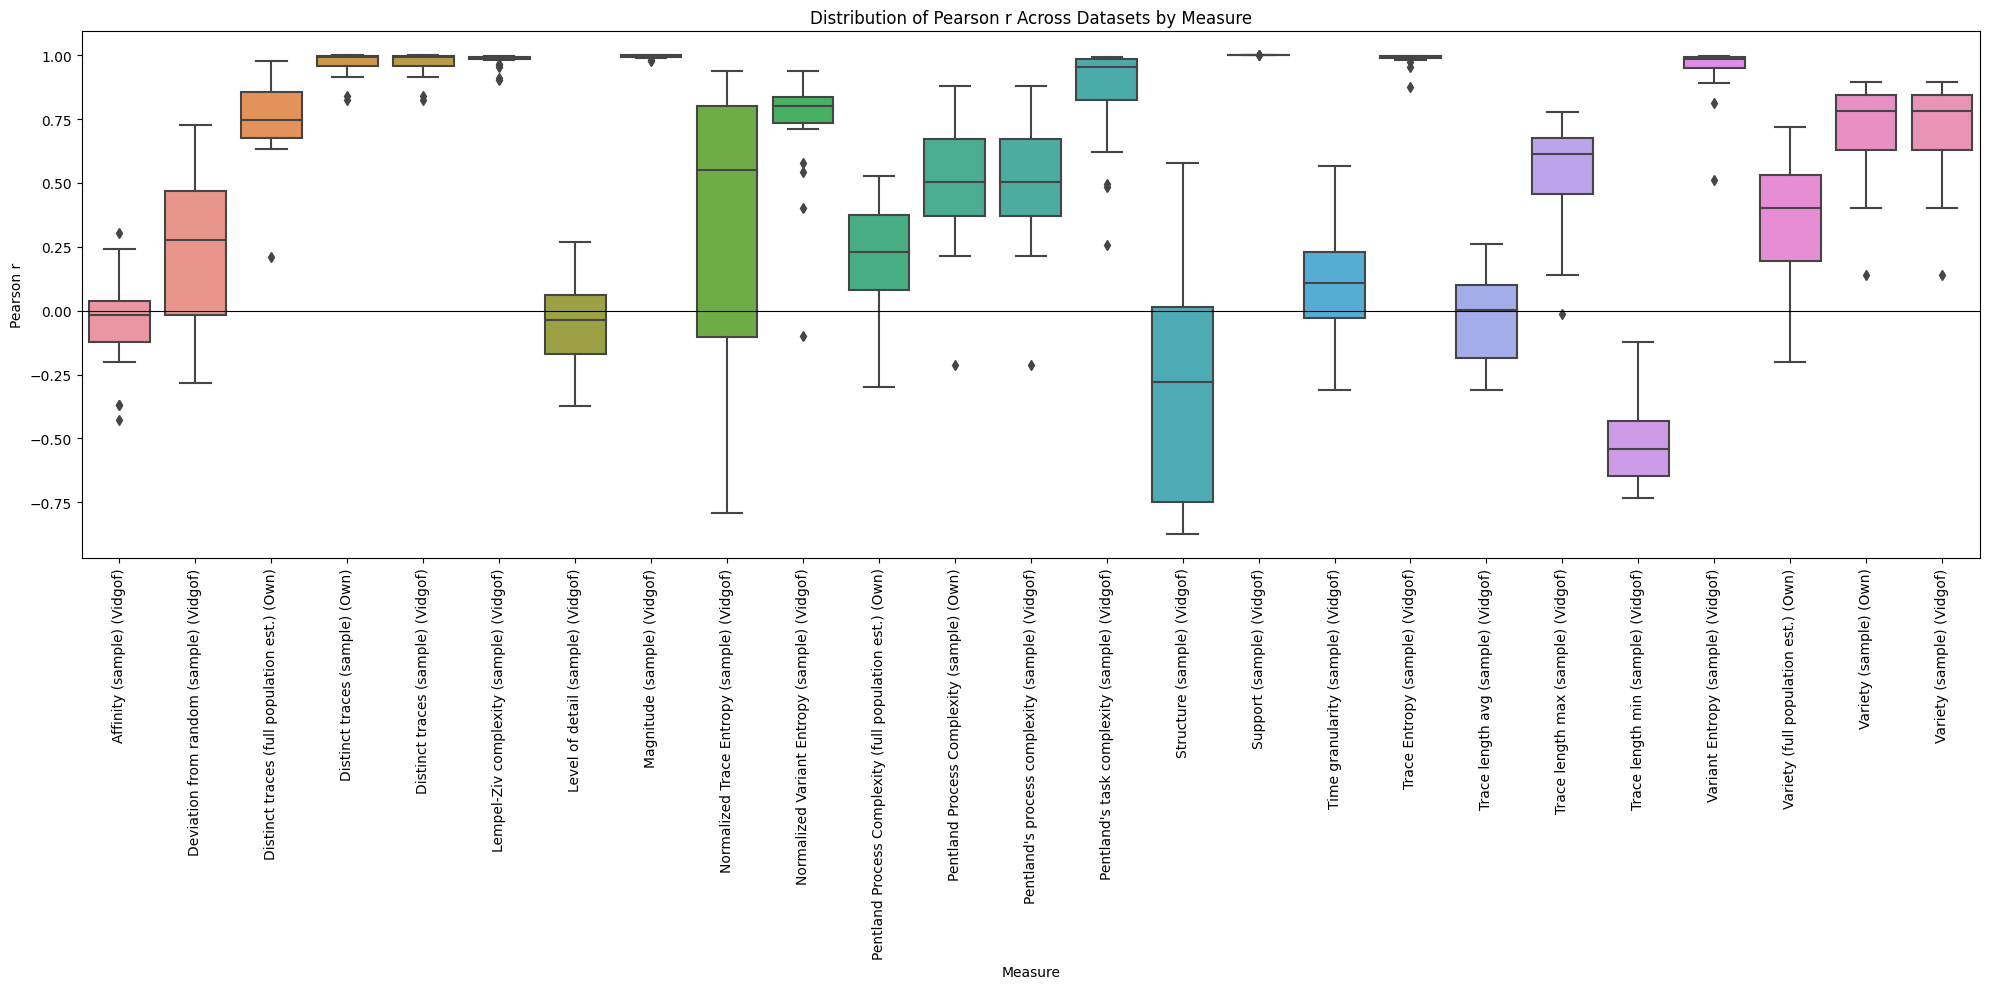

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten correlation_results into one long DataFrame
all_corrs = []
for dataset, df in correlation_results.items():
    for _, row in df.iterrows():
        all_corrs.append({
            "dataset": dataset,
            "measure": row["measure"],
            "pearson_r": row["pearson_r"]
        })

corr_df = pd.DataFrame(all_corrs)

# Sort measures for consistent x-axis order
order = sorted(corr_df["measure"].unique())

# Create Seaborn boxplot
plt.figure(figsize=(20, 10))
sns.boxplot(
    data=corr_df,
    x="measure",
    y="pearson_r",
    order=order
)

# Formatting
plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(rotation=90)
plt.ylabel("Pearson r")
plt.xlabel("Measure")
plt.title("Distribution of Pearson r Across Datasets by Measure")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

summary_rows = []

for measure in sorted({row["measure"] for df in correlation_results.values() for _, row in df.iterrows()}):
    r_values = []
    p_values = []
    sig_count = 0
    total_count = 0
    
    for dataset, df in correlation_results.items():
        row = df[df["measure"] == measure]
        if not row.empty:
            r = row["pearson_r"].values[0]
            p = row["p_value"].values[0]
            if pd.notna(r) and pd.notna(p):
                r_values.append(abs(r))
                p_values.append(p)
                total_count += 1
                if p <= 0.05:
                    sig_count += 1
    
    if total_count > 0:
        summary_rows.append({
            "measure": measure,
            "median_abs_r": np.median(r_values),
            "median_p_value": np.median(p_values),
            "pct_significant_(p<0.05)": (sig_count / total_count) * 100,
            "n_datasets": total_count
        })

summary_df = pd.DataFrame(summary_rows).sort_values("median_abs_r").reset_index(drop=True)
summary_df

,measure,median_abs_r,median_p_value,pct_significant_(p<0.05),n_datasets
0,Affinity (sample) (Vidgof),0.084759,5.581974e-01,4.545455,22
1,Level of detail (sample) (Vidgof),0.139476,4.396348e-01,0.000000,22
2,Trace length avg (sample) (Vidgof),0.141328,3.281511e-01,0.000000,22
3,Time granularity (sample) (Vidgof),0.181452,2.783148e-01,19.047619,21
4,Pentland Process Complexity (full population e...,0.286961,1.310233e-01,13.636364,22
5,Deviation from random (sample) (Vidgof),0.291407,5.911145e-02,45.454545,22
6,Structure (sample) (Vidgof),0.394507,2.894487e-02,59.090909,22
7,Variety (full population est.) (Own),0.402379,2.667502e-02,54.545455,22
8,Pentland Process Complexity (sample) (Own),0.503269,4.560839e-04,68.181818,22
9,Pentland's process complexity (sample) (Vidgof),0.503269,4.560839e-04,68.181818,22
